In [1]:
pip install numpy pandas tensorflow keras matplotlib scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Concatenate

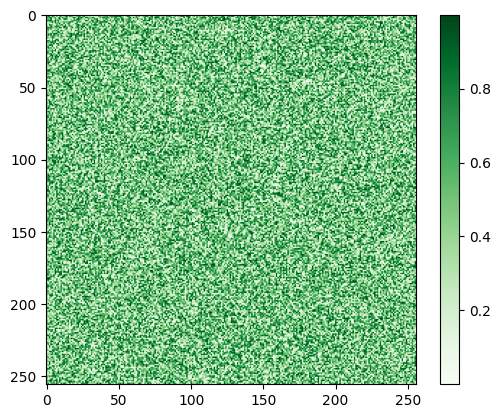

In [3]:
# Generate synthetic image data (e.g., NDVI-like spatial data)
def generate_synthetic_images(n_samples, img_height, img_width):
    return np.random.rand(n_samples, img_height, img_width, 1)  # 1 channel (grayscale)

n_samples = 1000  # Number of synthetic images
img_height, img_width = 256, 256  # Image dimensions
X_spatial = generate_synthetic_images(n_samples, img_height, img_width)

# Plot one of the synthetic images
plt.imshow(X_spatial[0, :, :, 0], cmap='Greens')
plt.colorbar()
plt.show()

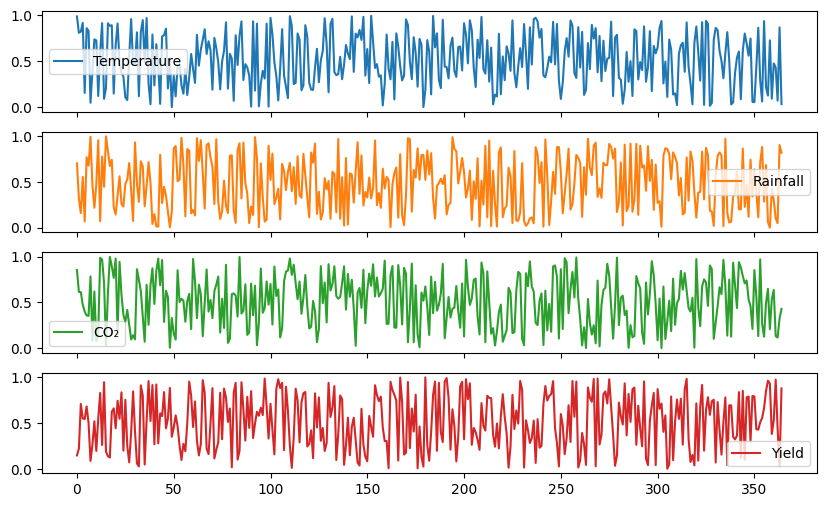

In [5]:
# Generate synthetic time-series data for temperature, rainfall, CO₂, and crop yields
def generate_synthetic_time_series(n_timesteps, n_features):
    return np.random.rand(n_timesteps, n_features)

n_timesteps = 365  # Number of time steps (e.g., 1 year of daily data)
n_features = 3  # Features: Temperature, Rainfall, CO₂
X_temporal = generate_synthetic_time_series(n_timesteps, n_features)

# Generate synthetic crop yields (as a regression target)
y_temporal = np.random.rand(n_timesteps)

# Convert to Pandas DataFrame for visualization
df = pd.DataFrame(X_temporal, columns=['Temperature', 'Rainfall', 'CO₂'])
df['Yield'] = y_temporal

# Plot synthetic climate data and crop yields
df.plot(subplots=True, figsize=(10, 6))
plt.show()

In [10]:
# Normalize spatial data (CNN input)
X_spatial = X_spatial / np.max(X_spatial)  # Normalize to 0-1
X_spatial
# Normalize temporal data (LSTM input)
scaler = MinMaxScaler()
X_temporal_scaled = scaler.fit_transform(X_temporal)
X_temporal_scaled

array([[0.99367606, 0.70467885, 0.85621022],
       [0.81446218, 0.3171611 , 0.61644058],
       [0.82750406, 0.1601632 , 0.613984  ],
       ...,
       [0.07157886, 0.0485614 , 0.11757369],
       [0.87327312, 0.90508399, 0.32571849],
       [0.03336548, 0.82094145, 0.430854  ]])

In [22]:
# Reshape temporal data for LSTM input (samples, timesteps, features)
X_temporal_reshaped = X_temporal_scaled.reshape(1, n_timesteps, n_features)
# Reshape target (crop yields) for LSTM output
y_temporal_reshaped = y_temporal.reshape(1, n_timesteps, 1)

In [23]:
n_spatial_samples = 1000  # Matching the number of spatial samples

# Generate synthetic time-series data for each sample (e.g., 365 timesteps for 1000 samples)
X_temporal = np.random.rand(n_spatial_samples, n_timesteps, n_features)

# Generate corresponding crop yield target for each spatial sample
y_temporal = np.random.rand(n_spatial_samples, n_timesteps)

# Normalize temporal data (same process as before)
X_temporal_scaled = scaler.fit_transform(X_temporal.reshape(-1, n_features))
X_temporal_reshaped = X_temporal_scaled.reshape(n_spatial_samples, n_timesteps, n_features)

# Now the target (yields) should match the number of spatial samples
y_temporal_reshaped = y_temporal.reshape(n_spatial_samples, n_timesteps, 1)


In [13]:
# CNN for spatial data
spatial_input = Input(shape=(img_height, img_width, 1))  # Input for images
x = Conv2D(32, (3, 3), activation='relu')(spatial_input)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)

In [14]:
# LSTM for time-series data
temporal_input = Input(shape=(n_timesteps, n_features))  # Input for time-series
y = LSTM(64, return_sequences=True)(temporal_input)
y = Flatten()(y)

In [17]:
# Combine CNN and LSTM outputs
combined = Concatenate()([x, y])

In [18]:
# Fully connected layers for final prediction
z = Dense(128, activation='relu')(combined)
output = Dense(n_timesteps, activation='linear')(z)  # Predict yield for each timestep

In [19]:
# Define and compile the model
model = Model(inputs=[spatial_input, temporal_input], outputs=output)
model.compile(optimizer='adam', loss='mse')

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 254, 254, 32)         320       ['input_1[0][0]']             
                                                                                                  
 input_2 (InputLayer)        [(None, 365, 3)]             0         []                            
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)         0         ['conv2d[0][0]']              
 D)                                                                                           

In [24]:
# Train the model
history = model.fit([X_spatial, X_temporal_reshaped], y_temporal_reshaped, epochs=10, batch_size=32)

Epoch 1/10
32/32 [==============================] - 41s 1s/step - loss: 15.0180
Epoch 2/10
32/32 [==============================] - 35s 1s/step - loss: 0.3670
Epoch 3/10
32/32 [==============================] - 36s 1s/step - loss: 0.3143
Epoch 4/10
32/32 [==============================] - 35s 1s/step - loss: 0.3038
Epoch 5/10
32/32 [==============================] - 35s 1s/step - loss: 0.2927
Epoch 6/10
32/32 [==============================] - 36s 1s/step - loss: 0.2814
Epoch 7/10
32/32 [==============================] - 35s 1s/step - loss: 0.2701
Epoch 8/10
32/32 [==============================] - 34s 1s/step - loss: 0.2589
Epoch 9/10
32/32 [==============================] - 34s 1s/step - loss: 0.2480
Epoch 10/10
32/32 [==============================] - 35s 1s/step - loss: 0.2374


In [25]:
# Evaluate the model
loss = model.evaluate([X_spatial, X_temporal_reshaped], y_temporal_reshaped)
print(f"Model Loss: {loss}")

32/32 [==============================] - 22s 671ms/step - loss: 0.2320
Model Loss: 0.232002854347229


In [26]:
# Predict crop yields using the model
predictions = model.predict([X_spatial, X_temporal_reshaped])
predictions

32/32 [==============================] - 21s 635ms/step


array([[0.12178938, 0.10168448, 0.05568898, ..., 0.20052485, 0.05250873,
        0.04719808],
       [0.12178938, 0.10168448, 0.05568898, ..., 0.20052485, 0.05250873,
        0.04719808],
       [0.12178938, 0.10168448, 0.05568898, ..., 0.20052485, 0.05250873,
        0.04719808],
       ...,
       [0.12178938, 0.10168448, 0.05568898, ..., 0.20052485, 0.05250873,
        0.04719808],
       [0.12178938, 0.10168448, 0.05568898, ..., 0.20052485, 0.05250873,
        0.04719808],
       [0.12178938, 0.10168448, 0.05568898, ..., 0.20052485, 0.05250873,
        0.04719808]], dtype=float32)

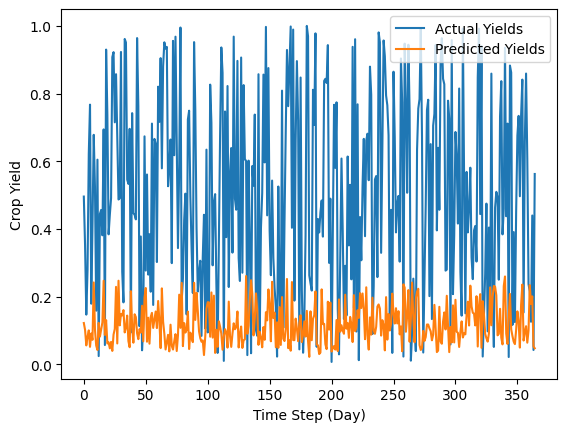

In [27]:
# Plot predicted yields vs actual yields for the first sample
plt.plot(y_temporal[0], label='Actual Yields')
plt.plot(predictions[0], label='Predicted Yields')
plt.xlabel('Time Step (Day)')
plt.ylabel('Crop Yield')
plt.legend()
plt.show()